# <a id='toc1_'></a>[Data Prep and Cleanup](#toc0_)

Our project examines the potential loss of homeowner insurance coverage due to climate disasters, evaluating how social inequalities affect by this process. In this notebook, we compile several datasets produced by different organizations, including data on insurance, population, housing, and climate disaster. They will compose the base dataset for this project. 

Given to the availability of data, our focus will be the State of California, which publishes (somewhat) detailed data about its FAIR Plan program. This program offers property insurance for homeowners who lost their coverage due to insurance company stopping offering policies in a given area. FAIR Plan coverage, thus, is our proxy measure of who is (and where people are) likely to lose insurance coverage through traditional market access. 

Our units of observation are ZIP Codes (more precisely, [ZIP Code Tabulation Area](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html)) as most of the data is provided at this scale. We also prioritize the 2018-2021 period given the overlap between datasets. 

**Table of contents**<a id='toc0_'></a>    
- [Data Prep and Cleanup](#toc1_)    
  - [Census Data](#toc1_1_)    
    - [Demography](#toc1_1_1_)    
    - [Housing (2021)](#toc1_1_2_)    
  - [Insurance Data](#toc1_2_)    
    - [Renewals](#toc1_2_1_)    
    - [Premiums, Claims, and Losses](#toc1_2_2_)    
    - [FAIR Plan (2022)](#toc1_2_3_)    
  - [Zillow Data (Housing Value Index)](#toc1_3_)    
  - [Disaster Data](#toc1_4_)    
  - [Consolidating data](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [13]:
import pandas as pd
import geopandas as gpd # you'll need geopandas for the last part of the notebook, but it's not required for most of the project
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [14]:
# base folders
RAW_DATA_DIR = Path('raw_data/')
CLEAN_DATA_DIR = Path('clean_data/')

In [15]:
# years to slice the data
start_year = 2018
end_year = 2021

## <a id='toc1_1_'></a>[Census Data](#toc0_)


The United States Census Bureau conducts the American Community Survey (ACS) — an ongoing survey that collects detailed information on social, economic, housing, and demographic characteristics of the U.S. population. The ACS provides two main types of data products based on the length of the collection period:

- [American Community Survey 1-Year Data (2009-2023)](https://www.census.gov/data/developers/data-sets/acs-1year.html):
These estimates are based on data collected over a single calendar year and are available for geographic areas with populations of 65,000 or more. They are more current but less precise due to smaller sample sizes. 

- [American Community Survey 5-Year Data (2009-2023)](https://www.census.gov/data/developers/data-sets/acs-5year.html):
These estimates aggregate data over a five-year period, providing more reliable statistics for small geographic areas, including Zip Code Tabulation Areas (ZCTAs), census tracts, and block groups. They are especially valuable for analyses involving small populations or finer spatial resolution.

In this notebook, we use ACS 5-Year (2018-2021) estimates to ensure statistical reliability across all ZCTAs in California, particularly when analyzing variables such as median housing costs, income levels. We use the ACS 1-Year (2018-2021) data for analyzing racial makeup.




### <a id='toc1_1_1_'></a>[Demography](#toc0_)

Median Income, and the percentage of "white-only" population are the key demographic metrics we analyzed.

In [16]:
# Median Income
median_income = pd.read_csv(RAW_DATA_DIR / 'median_incomes_flat.csv', index_col=0)

median_income.columns = ['ZIP Code', 'Avg Median Income', '% Avg Change Median Income', '% Change Median Income']

median_income['ZIP Code'] = median_income['ZIP Code'].astype(str)
median_income = median_income[['ZIP Code', 'Avg Median Income', '% Change Median Income']]

median_income.set_index('ZIP Code', inplace=True)
median_income

,Avg Median Income,% Change Median Income
ZIP Code,,
90001,48115.285714,0.703617
90002,43639.714286,0.651706
90003,44032.857143,0.592610
90004,53401.000000,0.345076
90005,42199.000000,0.625181
...,...,...
96145,94609.857143,0.702736
96146,88706.857143,0.561384
96148,80547.857143,0.167422


In [17]:
# Race 
# Note: we use percentage of "white-only" population as a proxy race, and this data is only available by county, not zip code.

white_pop = pd.read_csv(RAW_DATA_DIR / 'percent_white_population_flat.csv', index_col=0)

white_pop.columns = ['ZIP Code', 'Avg % White-only Pop', '% Avg Change % of White-only Pop', '% Change White-only Pop']

white_pop['ZIP Code'] = white_pop['ZIP Code'].astype(str)
white_pop = white_pop[['ZIP Code', 'Avg % White-only Pop', '% Change White-only Pop']]

white_pop.set_index('ZIP Code', inplace=True)
white_pop.sample(5)

,Avg % White-only Pop,% Change White-only Pop
ZIP Code,,
94106,44.428571,-6.7
92258,54.028571,-19.4
95838,53.957143,-11.5
95252,87.100000,-11.0
93517,81.414286,-11.2


### <a id='toc1_1_2_'></a>[Housing (2021)](#toc0_)

*** Note from EDA: "Median Home Value" is capped at $2,000,001 (censored data)

In [18]:
# number of housing units
housing_units = pd.read_csv(RAW_DATA_DIR / 'Housing Units in Census Zip Code Tabulation Areas of California (2021).csv')
housing_units = housing_units[['Entity properties name', 'Variable observation value']]
housing_units.columns=['ZIP Code', 'Housing Units']
housing_units.set_index('ZIP Code', inplace=True)

# median gross rent
gross_rent = pd.read_csv(RAW_DATA_DIR / 'Median Gross Rent of Housing Unit_ With Cash Rent in Census Zip Code Tabulation Areas of California (2021).csv')
gross_rent = gross_rent[['Entity properties name', 'Variable observation value']]
gross_rent.columns=['ZIP Code', 'Median Gross Rent ($)']
gross_rent.set_index('ZIP Code', inplace=True)

# median ownership costs
# Note: This dataset contains the median cost of housing units without mortgage
owner_cost = pd.read_csv(RAW_DATA_DIR / 'Median Cost of Housing Unit (Selected Monthly Owner Costs)_ Without Mortgage in Census Zip Code Tabulation Areas of California (2021).csv')
owner_cost = owner_cost[['Entity properties name', 'Variable observation value']]
owner_cost.columns=['ZIP Code', 'Median Owner Cost ($)']
owner_cost.set_index('ZIP Code', inplace=True)

# median home value
home_value = pd.read_csv(RAW_DATA_DIR / 'Median Home Value of Housing Unit_ Occupied Housing Unit, Owner Occupied in Census Zip Code Tabulation Areas of California (2021).csv')
home_value = home_value[['Entity properties name', 'Variable observation value']]
home_value.columns=['ZIP Code', 'Median Home Value - Census ($)']
home_value.set_index('ZIP Code', inplace=True)

housing = pd.concat([housing_units, gross_rent, owner_cost, home_value], axis=1).dropna()
housing.index = housing.index.astype(str)


In [19]:
housing.sample(3)

,Housing Units,Median Gross Rent ($),Median Owner Cost ($),Median Home Value - Census ($)
ZIP Code,,,,
95130,4735,1969.0,846.0,1409500.0
95131,10036,2808.0,824.0,976300.0
92124,11742,2673.0,764.0,704400.0


## <a id='toc1_2_'></a>[Insurance Data](#toc0_)

California requires insurers with written premiums above of $10 million to submit a biennial report to the Insurance Commissioner with its residential property experience data for the previous two years. The data is processed by the Department of Insurance and the aggregates are published at zipcode level, including information about the number of policies, renewals, premiums, and losses. In this project, we used the following datasets:

- [New, renewed, and non-renewed insurance policies, 2015-2021](https://www.insurance.ca.gov/01-consumers/200-wrr/upload/Residential-Insurance-Policy-Analysis-by-County-2015-to-2021-2.pdf) 
- [Earned premiums, claims, and losses in residential units, 2018-2023](https://www.insurance.ca.gov/01-consumers/200-wrr/WildfireRiskInfoRpt.cfm)

Besides "regular" insurance data, we also include information about California's FAIR Plan. The California FAIR Plan provides basic insurance coverage for high-risk properties when traditional insurance companies will not. It has recently expanded to offer higher coverage limits of $3 million for residential policyholders and $20 million for commercial policies per location, serving as a safety net for properties that can't obtain coverage in the standard insurance market. The available data comes from these two datasets:
- [Residential Structures Insured under a FAIR Plan Policy, 2022](https://www.insurance.ca.gov/01-consumers/200-wrr/upload/Number-of-Residential-Dwelling-Units-Insured-in-2022-FAIR-Plan-vs-Voluntary.pdf)
- [Residential policies  by the program, 2020-2024](https://www.cfpnet.com/wp-content/uploads/2024/11/CFP5yearPIFGrowthbyzipcodethrough09302024(Residential%20line)20241112v001.pdf)
- [Residential exposure covered by the program, 2020-2024](https://www.cfpnet.com/wp-content/uploads/2024/11/CFP5yearTIVGrowthbyzipcodethrough09302024(Residentialline)20241112v001.pdf)

*** Note: the best available data covers only 2022 and will be used a the target for our model.

### <a id='toc1_2_1_'></a>[Renewals](#toc0_)

In [20]:
# loading and performing initial processing on the renewals data
renewals = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Voluntary-Market-New-Renew-NonRenew-by-ZIP-2015-2021.xlsx', dtype={'ZIP Code': str})

# removing zipcodes not associated with a county
renewals = renewals[renewals['County'].isnull() == False]

# keeping only columns of interest and renaming
cols = ["ZIP Code", "Year", "New", "Renewed", "Insured-Initiated Nonrenewed", "Insurer-Initiated Nonrenewed"]
renewals = renewals[cols].copy()

renaming = {
    'New' : 'New Policies',
    'Renewed': 'Renewed Policies',
    'Insured-Initiated Nonrenewed': 'Nonrenewed Policies (by Owner)',
    'Insurer-Initiated Nonrenewed': 'Nonrenewed Policies (by Company)',
}

renewals.rename(columns=renaming, inplace=True)

renewals.sample(3)

,ZIP Code,Year,New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company)
8968,95942,2018,71,573,47,15
15285,95735,2021,37,319,40,31
3226,92509,2016,2167,13556,1486,511


The original dataset provides raw counts of policy renewals and includes multiple years. Based on this information, we can calculate some extra features, including the relative importance of each count (i.e., percentages) and their change over time.

In [21]:
# number of non-renewed policies and  expiring policies (or contracts up to renewal) 
renewals['Nonrenewed Policies'] = renewals['Nonrenewed Policies (by Owner)'] + renewals['Nonrenewed Policies (by Company)']
renewals['Expiring Policies'] = renewals['Nonrenewed Policies'] + renewals['Renewed Policies']

In [22]:
# filtering years of interest
cond1 = renewals['Year'] >= start_year
cond2 = renewals['Year'] <= end_year

renewals_filtered = renewals.loc[cond1 & cond2].copy()
renewals_filtered = renewals_filtered.groupby('ZIP Code', as_index=False).sum()
renewals_filtered.drop(columns='Year', inplace=True)

renewals_filtered.sample(3)

,ZIP Code,New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company),Nonrenewed Policies,Expiring Policies
1591,95229,23,121,20,14,34,155
2072,96024,104,1277,105,47,152,1429
38,90039,3118,25960,2386,534,2920,28880


In [23]:
# percentage of non-renewed policies of the expiring policies
renewals_filtered['% Nonrenewed Policies'] = renewals_filtered['Nonrenewed Policies'] / renewals_filtered['Expiring Policies']

# percentage of policies not-renewals by the initiative of the owner or company
renewals_filtered['% Nonrenewed Policies (by Owner)'] = renewals_filtered['Nonrenewed Policies (by Owner)'] / renewals_filtered['Expiring Policies']
renewals_filtered['% Nonrenewed Policies (by Company)'] = renewals_filtered['Nonrenewed Policies (by Company)'] / renewals_filtered['Expiring Policies']

renewals_filtered.sample(3)

,ZIP Code,New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company),Nonrenewed Policies,Expiring Policies,% Nonrenewed Policies,% Nonrenewed Policies (by Owner),% Nonrenewed Policies (by Company)
1754,95470,726,6048,496,218,714,6762,0.105590,0.073351,0.032239
772,92692,6927,48144,5845,1144,6989,55133,0.126766,0.106016,0.020750
323,91729,1,1,0,0,0,1,0.000000,0.000000,0.000000


In [24]:
# calculating change over time based on the start and end years
cond1 = renewals['Year'] == start_year
cond2 = renewals['Year'] == end_year

renewals_change = renewals[cond1 | cond2].copy().sort_values(['ZIP Code', 'Year']).set_index('ZIP Code')

renewals_change = renewals_change.groupby(['ZIP Code']).pct_change().dropna().copy().drop(columns='Year')
renewals_change.replace([np.inf, -np.inf], np.nan, inplace=True)

renewals_change.columns = ['% Change - ' + col for col in renewals_change.columns]
renewals_change.reset_index(inplace=True)
renewals_change.sample(3)

,ZIP Code,% Change - New Policies,% Change - Renewed Policies,% Change - Nonrenewed Policies (by Owner),% Change - Nonrenewed Policies (by Company),% Change - Nonrenewed Policies,% Change - Expiring Policies
1317,95444,0.260870,0.117391,1.083333,0.333333,0.933333,0.167347
1051,94609,0.149780,0.017349,0.306590,-0.025000,0.244755,0.041039
1516,95824,-0.071085,0.027201,-0.103145,0.095455,-0.060099,0.013156


In [25]:
# merging datasets 
renewals_change['ZIP Code'] = renewals_change['ZIP Code'].astype(str)
renewals_filtered['ZIP Code'] = renewals_filtered['ZIP Code'].astype(str)

renewals_reworked = pd.merge(renewals_filtered, renewals_change, on='ZIP Code')
renewals_reworked.set_index('ZIP Code', inplace=True)
renewals_reworked.sample(3)

,New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company),Nonrenewed Policies,Expiring Policies,% Nonrenewed Policies,% Nonrenewed Policies (by Owner),% Nonrenewed Policies (by Company),% Change - New Policies,% Change - Renewed Policies,% Change - Nonrenewed Policies (by Owner),% Change - Nonrenewed Policies (by Company),% Change - Nonrenewed Policies,% Change - Expiring Policies
ZIP Code,,,,,,,,,,,,,,,
95388,1403,9281,1030,207,1237,10518,0.117608,0.097927,0.019681,-0.188482,0.071043,0.087137,-0.206349,0.026316,0.065665
92587,4798,20439,3287,1322,4609,25048,0.184007,0.131228,0.052779,0.337259,-0.019751,0.197461,1.248588,0.407449,0.042288
95601,95,422,64,44,108,530,0.203774,0.120755,0.083019,2.700000,-0.192982,0.900000,5.666667,2.000000,0.031496


### <a id='toc1_2_2_'></a>[Premiums, Claims, and Losses](#toc0_)

This dataset covers certain types of residential policies (Dwelling Fire policies, Homeowners policies, Earthquake policies) and include information about total earned premiums as well as number of claims and total losses paid by insurance companies for fire- and smoke-related incidents.  Similar to renewal data, we will compute the aggregate values and percentage changes for the timespan of interest.

Note: The column "Total Exposure" seems to contain problematic data. The value for total exposure--the amount covered by the insurers--is much smaller than premiums they received in a particular zipcode, which doesn't make sense. Therefore, we're removing the data.

In [26]:
premiums = pd.read_excel(RAW_DATA_DIR / 'Residential-Property-Coverage-Amounts-Wildfire-Risk-and-Losses.xlsx', sheet_name='Cleaned', header=3)

# removing "Grand total" and "County" rows from the dataset 
premiums = premiums[premiums.Zipcode.apply(type) == int]

# getting columns for claims (n.) and losses ($)
cols_claim = []
cols_losses = []

for col in premiums.columns[6:]:
    if col[-6:] == 'Claims':
        cols_claim.append(col)
    else:
        cols_losses.append(col)

# calculating total numbers of claims and values in losses
premiums['Claims (Fire and Smoke)'] = premiums[cols_claim].sum(axis=1)
premiums['Losses (Fire and Smoke) ($)'] = premiums[cols_losses].sum(axis=1)

# keeping only the columns of interest
cols = ['Zipcode', 'Year', 'Earned Premium', 'Claims (Fire and Smoke)', 'Losses (Fire and Smoke) ($)']

# filtering and renaming columns
premiums = premiums[cols].rename(columns={'Zipcode': 'ZIP Code', 'Earned Premium': 'Earned Premium ($)'})
premiums['ZIP Code'] = premiums['ZIP Code'].astype(str)
premiums.sample(3)

,ZIP Code,Year,Earned Premium ($),Claims (Fire and Smoke),Losses (Fire and Smoke) ($)
19537,93015,2019,2355124,11,44209.0
71449,95986,2023,491,0,0.0
70521,94587,2023,674319,1,12097.0


In [27]:
# calculating the aggregate values for the timespan
cond1 = premiums['Year'] >= start_year
cond2 = premiums['Year'] <= end_year

premiums_aggs = premiums[cond1 & cond2].groupby(['ZIP Code']).sum().reset_index()
premiums_aggs = premiums_aggs.drop(columns=['Year'])

premiums_aggs.sample(3)

,ZIP Code,Earned Premium ($),Claims (Fire and Smoke),Losses (Fire and Smoke) ($)
1878,95317,134975,0,0.0
2255,95903,335374,2,72556.0
1428,94085,11649411,18,985065.0


In [28]:
# filtering years and getting growth
cond1 = premiums['Year'] == start_year
cond2 = premiums['Year'] == end_year

# creating pivot table with start and end years
premiums_pivot = pd.pivot_table(premiums[cond1 | cond2], index='ZIP Code', columns='Year').dropna()
premiums_pivot.columns = [f'{str(s[1])}_{s[0]}' for s in premiums_pivot.columns]
premiums_pivot = premiums_pivot.reset_index()

# calculating growth
premiums_pivot['% Change - Earned Premiums'] = premiums_pivot[['2018_Earned Premium ($)', '2021_Earned Premium ($)']].pct_change(axis=1).iloc[:, 1]
premiums_pivot['% Change - Claims (Fire and Smoke)'] = premiums_pivot[['2018_Claims (Fire and Smoke)', '2021_Claims (Fire and Smoke)']].pct_change(axis=1).iloc[:, 1]
premiums_pivot['% Change - Losses (Fire and Smoke)'] = premiums_pivot[['2018_Losses (Fire and Smoke) ($)', '2021_Losses (Fire and Smoke) ($)']].pct_change(axis=1).iloc[:, 1]

premiums_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
premiums_pivot.sample(3)

,ZIP Code,2018_Claims (Fire and Smoke),2021_Claims (Fire and Smoke),2018_Earned Premium ($),2021_Earned Premium ($),2018_Losses (Fire and Smoke) ($),2021_Losses (Fire and Smoke) ($),% Change - Earned Premiums,% Change - Claims (Fire and Smoke),% Change - Losses (Fire and Smoke)
1063,93639,0.000000,0.0,2.120000e+02,1.644000e+03,0.000000,0.000000,6.754717,NaN,NaN
190,91016,1.285714,3.0,1.148134e+06,1.525592e+06,47845.571429,360638.857143,0.328758,1.333333,6.53756
12,90013,0.200000,0.4,1.670622e+05,2.464582e+05,10000.000000,1719.800000,0.475248,1.000000,-0.82802


In [29]:
df1 = premiums_pivot[['ZIP Code', '% Change - Earned Premiums', '% Change - Claims (Fire and Smoke)', '% Change - Losses (Fire and Smoke)']].copy()
df2 = premiums_aggs.copy()

premiums_reworked = pd.merge(df2, df1, on='ZIP Code')
premiums_reworked.set_index('ZIP Code', inplace=True)

premiums_reworked.sample(3)

,Earned Premium ($),Claims (Fire and Smoke),Losses (Fire and Smoke) ($),% Change - Earned Premiums,% Change - Claims (Fire and Smoke),% Change - Losses (Fire and Smoke)
ZIP Code,,,,,,
93262,67783,2,38864.0,0.680343,NaN,NaN
92314,35700959,34,2003664.0,0.636903,-0.625,-0.706887
90720,27137348,54,3175470.0,0.340214,1.000,6.791154


### <a id='toc1_2_3_'></a>[FAIR Plan (2022)](#toc0_)

In [30]:
fair22 = pd.read_excel(RAW_DATA_DIR / 'full_residential_units_insured_2022.xlsx')

cols = ['ZIP Code', "Voluntary Market Units", "FAIR Plan Units"]
fair22 = fair22[cols]

# calculate percentages
fair22['Total Res Units'] = fair22['Voluntary Market Units'] + fair22['FAIR Plan Units']
fair22['% Market Units'] = fair22['Voluntary Market Units'] / fair22['Total Res Units']
fair22['% FAIR Plan Units'] = fair22['FAIR Plan Units'] / fair22['Total Res Units']

fair22.head(2)

,ZIP Code,Voluntary Market Units,FAIR Plan Units,Total Res Units,% Market Units,% FAIR Plan Units
0,90001,6913,2104,9017,0.766663,0.233337
1,90002,6534,1330,7864,0.830875,0.169125


Besides the 2022 dataset, California also published general information about total exposure covered by FAIR Plan policies, which we're incorporating below. It's potentially a secondary target variable.

In [31]:
columns_exp = ['ZIP Code', 
               'growth_exp_23_24', 'exposure_24',
               'growth_exp_22_23', 'exposure_23',
               'growth_exp_21_22', 'Total Exposure ($)',
               'growth_exp_20_21', 'exposure_21',
               'exposure_20']

fair_exp = pd.read_excel(RAW_DATA_DIR / 'CFP5yearTIVGrowthbyzipcodethrough09302024(Residentialline)20241112v001_unlocked.xlsx', names=columns_exp)

# removing rows that doesn't contain actual data (totals, etc.)
from pandas.api.types import is_integer, is_number
fair_exp = fair_exp[fair_exp['ZIP Code'].apply(is_integer)].copy()

# cleaning up exposure data
def clean_exposure(value):
    try:
        return float(value)
    except ValueError:
        return np.nan
    
fair_exp['Total Exposure ($)'] = fair_exp['Total Exposure ($)'].map(clean_exposure)
fair_exp.drop(index=[1670], inplace=True)  # removing duplicated data

fair_exp.sample(3)

,ZIP Code,growth_exp_23_24,exposure_24,growth_exp_22_23,exposure_23,growth_exp_21_22,Total Exposure ($),growth_exp_20_21,exposure_21,exposure_20
263,95565,1.23,13201732,1.316,5919581,4.715,2555909.0,0.042,447211,429334
1531,96016,0.74,41866587,0.375,24067099,0.488,17499641.0,0.678,11761910,7010804
1477,95112,0.851,61579059,-0.088,33264130,-0.083,36488764.0,-0.072,39810012,42908062


In [32]:
# merging exposure column
fair = pd.merge(fair22, fair_exp[['ZIP Code', 'Total Exposure ($)']], on='ZIP Code')
fair['ZIP Code'] = fair['ZIP Code'].astype(str)
fair.set_index('ZIP Code', inplace=True)

In [33]:
fair.sample(3)

,Voluntary Market Units,FAIR Plan Units,Total Res Units,% Market Units,% FAIR Plan Units,Total Exposure ($)
ZIP Code,,,,,,
93545,574,12,586,0.979522,0.020478,6711121.0
91436,4632,214,4846,0.955840,0.044160,344093321.0
90014,56,0,56,1.000000,0.000000,NaN


## <a id='toc1_3_'></a>[Zillow Data (Housing Value Index)](#toc0_)

Zillow Housing Value Index (ZHVI), overall, represents the “typical” home value for a region. It’s calculated as a weighted average of the middle third of homes in a given region--therefore, it reflects the typical value for homes in the 35th to 65th percentile range.

The base dataset can be found [here](https://www.zillow.com/research/data/) with the Data Type: "ZHVI All Homes (SFR, Condo/Co-Op) Time Series, Smoothed, Seasonally Adjusted($)" and "Zip Code" for "Geography." Additional information about ZHVI is available [here](https://www.zillow.com/research/zhvi-user-guide/).

In [34]:
zillow = pd.read_csv(RAW_DATA_DIR / "Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month_adjusted.csv", date_format='%Y-%m-%d', parse_dates=[2,3,4,5,6,])

# Filter rows where the STATE column is 'CA'
zillow = zillow[zillow['State'] == 'CA']

# Filter the house value for Dec 31st of each year
non_date_cols = ['RegionName', 'State']
date_cols = pd.date_range(start='2015-12-31', periods=10, freq='YE').strftime('%m/%d/%Y').tolist()
columns_to_keep = non_date_cols + date_cols

# Keep only those columns (skip missing ones to avoid KeyError)
existing_cols = [col for col in columns_to_keep if col in zillow.columns]
zillow = zillow[existing_cols]

# Rename columns to have a consistent format
zillow.columns = non_date_cols + zillow[date_cols].columns.str.slice(-4).tolist()

# Dropping data that weren't interested in 
cols_to_drop = ['State', '2015', '2016', '2017', '2022', '2023', '2024']
zillow.drop(columns=cols_to_drop, inplace=True)

# Renaming columns for clarity
zillow.rename(columns={'RegionName': 'ZIP Code',
                          '2018': 'Zillow Home Value 2018 ($)',
                          '2019': 'Zillow Home Value 2019 ($)',
                          '2020': 'Zillow Home Value 2020 ($)',
                          '2021': 'Zillow Home Value 2021 ($)'}, inplace=True)
                          
zillow['ZIP Code'] = zillow['ZIP Code'].astype(str)
zillow.dropna(inplace=True)
zillow.set_index('ZIP Code', inplace=True)

zillow.head()

,Zillow Home Value 2018 ($),Zillow Home Value 2019 ($),Zillow Home Value 2020 ($),Zillow Home Value 2021 ($)
ZIP Code,,,,
90011,443282.5808,459312.4160,506920.1260,560746.1110
90650,513295.6656,526093.8573,581498.8551,660390.8548
91331,504148.1256,516199.8496,576276.3692,643635.0577
90044,474820.6675,498004.1190,549195.7913,618134.0289
92336,452715.2279,465611.3794,508069.8122,623341.2874


In [35]:
# calculating mean and change over time
zillow['Zillow Mean Home Value ($)'] = zillow[['Zillow Home Value 2018 ($)', 'Zillow Home Value 2019 ($)', 'Zillow Home Value 2020 ($)', 'Zillow Home Value 2021 ($)']].mean(axis=1)
zillow['% Change - Zillow Home Value'] = zillow[['Zillow Home Value 2018 ($)', 'Zillow Home Value 2021 ($)']].pct_change(axis=1).iloc[:, 1]


zillow.sample(3)


,Zillow Home Value 2018 ($),Zillow Home Value 2019 ($),Zillow Home Value 2020 ($),Zillow Home Value 2021 ($),Zillow Mean Home Value ($),% Change - Zillow Home Value
ZIP Code,,,,,,
93449,777681.4392,776580.1652,829308.8433,994342.2831,844478.182700,0.278598
92352,428043.0644,428908.4605,491084.5576,671390.9064,504856.747225,0.568513
91708,502840.9839,498647.1200,525241.5659,659896.0346,546656.426100,0.312335


## <a id='toc1_4_'></a>[Disaster Data](#toc0_)

Disaster data is provided by the State of California and published at county level. The data was previously preprocessed elsewhere, including converting counties in to zipcodes (by considering that every zipcode in a given county was affect by the disaster.)

In [36]:
disasters = pd.read_csv(RAW_DATA_DIR / 'cleaned_climate_disasters.csv')
disasters.sample(3)

,ZIP,DATE,DISASTER
1378,94947,2024,Storm
8701,93552,2020,Fire
7609,95967,2021,Drought


In [37]:
range1 = list(range(2022-1, 2022))
range3 = list(range(2022-3, 2022))
range5 = list(range(2022-5, 2022))
range10 = list(range(2022-10, 2022))

In [38]:
all_disasters = pd.pivot_table(disasters, index='ZIP', columns='DATE', aggfunc='count', fill_value=0)
all_disasters.columns = [x[1] for x in all_disasters.columns]

all_disasters['All Disasters 1y'] = all_disasters[range1].sum(axis=1)
all_disasters['All Disasters 3y'] = all_disasters[range3].sum(axis=1)
all_disasters['All Disasters 5y'] = all_disasters[range5].sum(axis=1)
all_disasters['All Disasters 10y'] = all_disasters[range10].sum (axis=1)

all_disasters.iloc[:, -4:].sample(5)

,All Disasters 1y,All Disasters 3y,All Disasters 5y,All Disasters 10y
ZIP,,,,
91950,0,2,2,3
95501,3,6,7,11
95407,0,2,2,3
94572,2,4,5,6
93260,3,5,8,9


In [39]:
fire_disasters = disasters[disasters['DISASTER'] == 'Fire'].copy()
fire_disasters = pd.pivot_table(fire_disasters, index='ZIP', columns='DATE', aggfunc='count', fill_value=0)

fire_disasters.columns = [x[1] for x in fire_disasters.columns]

fire_disasters['Fire Disasters 1y'] = fire_disasters[range1].sum(axis=1)
fire_disasters['Fire Disasters 3y'] = fire_disasters[range3].sum(axis=1)
fire_disasters['Fire Disasters 5y'] = fire_disasters[range5].sum(axis=1)
fire_disasters['Fire Disasters 10y'] = fire_disasters[range10].sum (axis=1)

fire_disasters.iloc[:, -4:].sample(5)

,Fire Disasters 1y,Fire Disasters 3y,Fire Disasters 5y,Fire Disasters 10y
ZIP,,,,
92036,0,3,5,7
95936,0,2,2,3
95055,0,2,2,3
94122,0,2,2,3
90508,0,5,8,11


In [40]:
climate_disasters = pd.concat([all_disasters.iloc[:, -4:], fire_disasters.iloc[:, -4:]], axis=1)
climate_disasters.index.name = 'ZIP Code'
climate_disasters.index = climate_disasters.index.astype(str)

climate_disasters.sample(3)

,All Disasters 1y,All Disasters 3y,All Disasters 5y,All Disasters 10y,Fire Disasters 1y,Fire Disasters 3y,Fire Disasters 5y,Fire Disasters 10y
ZIP Code,,,,,,,,
91330,1,7,11,17,0,5,8,11
91896,1,7,11,17,0,5,8,11
94282,2,4,5,6,0,2,2,3


## <a id='toc1_5_'></a>[Consolidating data](#toc0_)

In [41]:
dfs = [housing, renewals_reworked, premiums_reworked, fair, zillow, climate_disasters, white_pop, median_income]
concat = pd.concat(dfs, axis=1)
concat.sample(3)

,Housing Units,Median Gross Rent ($),Median Owner Cost ($),Median Home Value - Census ($),New Policies,Renewed Policies,Nonrenewed Policies (by Owner),Nonrenewed Policies (by Company),Nonrenewed Policies,Expiring Policies,...,All Disasters 5y,All Disasters 10y,Fire Disasters 1y,Fire Disasters 3y,Fire Disasters 5y,Fire Disasters 10y,Avg % White-only Pop,% Change White-only Pop,Avg Median Income,% Change Median Income
ZIP Code,,,,,,,,,,,,,,,,,,,,,
92802,12633.0,1734.0,608.0,577500.0,2140.0,16265.0,1678.0,421.0,2099.0,18364.0,...,7.0,8.0,0.0,2.0,4.0,5.0,56.085714,-15.7,67962.571429,0.536755
92147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,0.0,2.0,2.0,3.0,64.514286,-17.8,NaN,NaN
94929,451.0,3501.0,1501.0,1265000.0,140.0,1083.0,119.0,13.0,132.0,1215.0,...,2.0,3.0,0.0,2.0,2.0,3.0,75.757143,-7.8,156583.571429,1.191184


In [42]:
concat.to_csv(CLEAN_DATA_DIR / 'full_dataset.csv')
concat.dropna().to_csv(CLEAN_DATA_DIR / 'cleaned_data.csv')

## Geospatial Data

This dataset is mostly for visualizations. While there are several geospatial datasets available, we used the preprocessed ones published by [Open Data DE](https://github.com/OpenDataDE/State-zip-code-GeoJSON/).

In [43]:
zipcodes = gpd.read_file("https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/refs/heads/master/ca_california_zip_codes_geo.min.json")

# filtering cols
zipcodes = zipcodes[['ZCTA5CE10', 'GEOID10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry']]
zipcodes.rename(columns={'ZCTA5CE10': 'ZIP Code'}, inplace=True)

zipcodes.sample(3)

,ZIP Code,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
1531,94710,0694710,5566008,5864359,+37.8639140,-122.3064650,"POLYGON ((-122.29701 37.88024, -122.29591 37.8..."
1324,95543,0695543,264109164,635589,+41.8708123,-123.8627705,"POLYGON ((-123.78839 41.99613, -123.78727 41.9..."
1708,92084,0692084,67781555,49687,+33.2199347,-117.2026060,"POLYGON ((-117.23583 33.25656, -117.23568 33.2..."


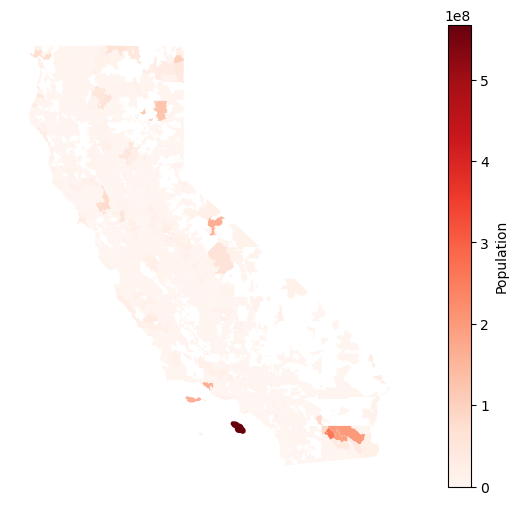

In [44]:
# simple map with area of water in that zipcode
ax = zipcodes.plot(column='AWATER10',
                   cmap='Reds',
                   figsize=(10, 6),
                   legend=True,
                   legend_kwds={'label': 'Population'},
                   ax=None)

ax.set_axis_off();

In [45]:
# using feather format, because it's much more efficient
zipcodes.to_feather(CLEAN_DATA_DIR / 'ca_zipcodes.feather')

The base dataset is done!